In [31]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
df.sort_values(by=['prod'], inplace=True)
print(df.shape)

# Select first 160 rows as training set
df_train = df.iloc[:160, :]
df_test = df.iloc[160:, :]

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

df_train.to_csv('../data/carotenoid_train.csv')
df_test.to_csv('../data/carotenoid_test.csv')

(168, 9)
Training set shape: (160, 9)
Test set shape: (8, 9)


Dataset size: (160, 9)


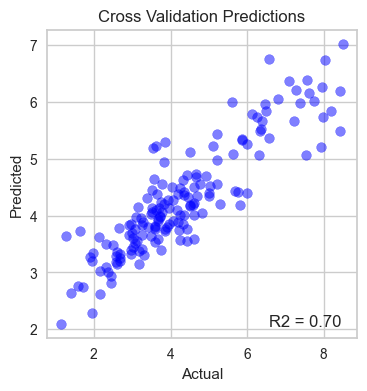

In [33]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

from src import plot_multiomics
from straindesignxai.main import DataLoader

file_path = "../data/carotenoid_train.csv"
model_path = "../models/xgb_carotenoid.pkl"

input_var = ["ERG8", "ERG10", "ERG12", "ERG13", "ERG19", "ERG20", "IDI1", "tHMG1"]
response_var = ["prod"]

d = DataLoader(file_path, input_var, response_var)  

# load or train ml model
try:
    d.load_model(model_path)
except FileNotFoundError:
    d.train_xgb(n_iter=25)
    d.save_model(model_path)

d.plot_R2()

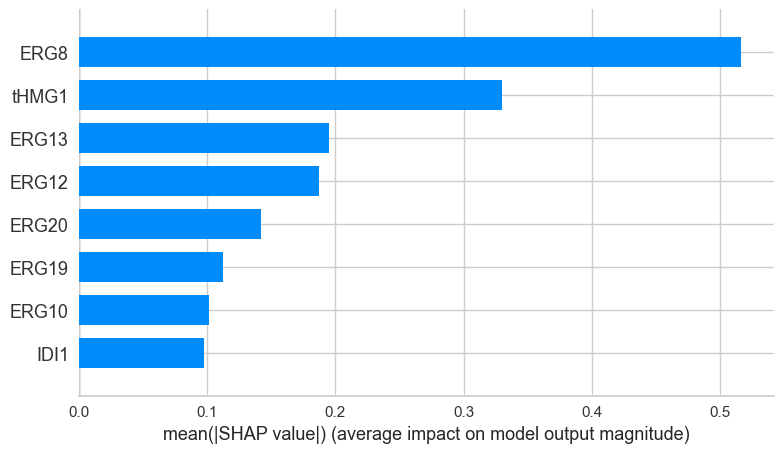

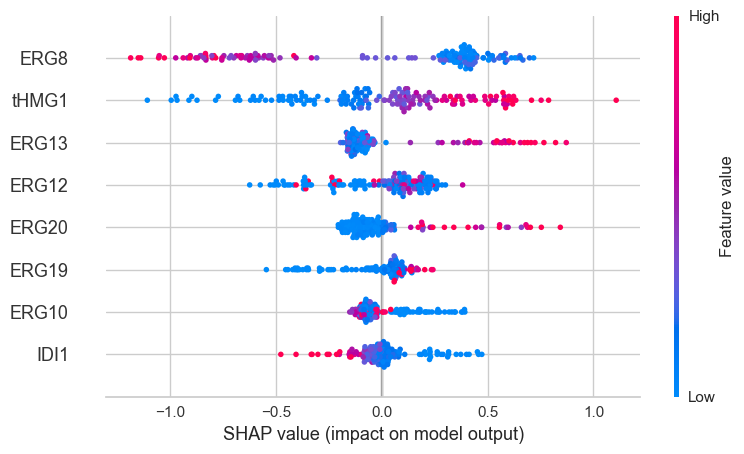

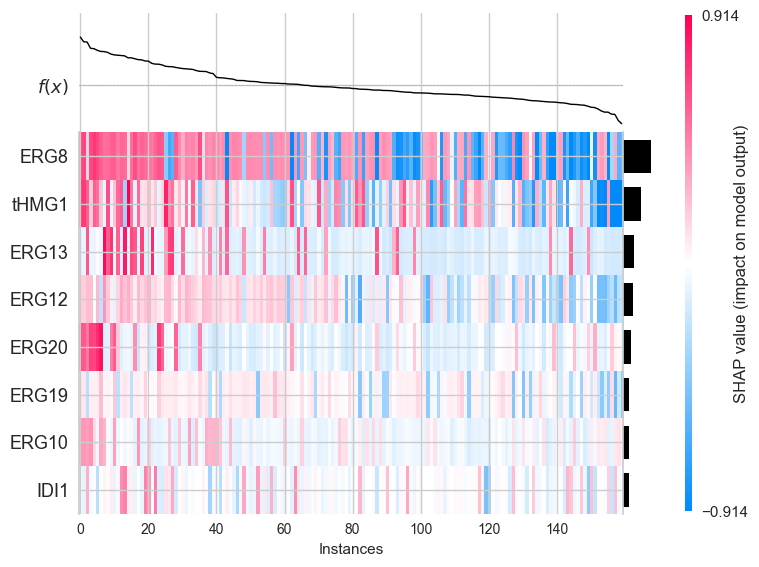

In [34]:
d.get_shap_values()

In [38]:
d.supervised_clustering()
d.df["pred"] = d.model.predict(d.df.drop(["prod", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    d.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)

top_prod_cls = d.df[d.df["cluster"] == top_cluster]
top_prod_cls

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod,cluster,pred
71,8.823257,0.870784,1.248800,7.703477,0.749858,0.975727,0.883703,0.800187,1.144454,4,2.097812
73,1.698056,1.439478,2.420113,9.607575,0.981413,1.200572,2.904848,2.233062,1.275247,4,3.643625
126,4.749587,5.418114,1.277682,4.773557,6.439441,9.935302,2.013810,0.664684,1.390393,4,2.639051
30,0.981933,1.089061,1.047913,5.326942,0.973334,0.982513,0.931936,0.781341,1.588769,4,2.753414
104,1.429410,4.043900,15.118976,2.556124,0.711555,0.939448,0.885076,4.317836,1.644396,4,3.722671
154,12.598451,2.786098,16.177743,1.335978,0.532444,0.704949,0.753582,7.501033,1.727037,4,2.752873
119,14.924336,4.087113,2.160429,3.554365,1.491255,1.618441,1.878040,3.483932,1.888575,4,3.275872
74,8.102982,0.917931,1.273309,6.081725,0.769132,3.472016,1.509537,0.890214,1.944744,4,2.280344
115,6.737247,4.425878,7.462690,2.738367,2.649743,2.116287,1.828413,4.101330,1.989415,4,3.343355
82,4.620429,4.261566,1.329452,1.503012,0.938610,1.156564,5.365471,4.938406,2.137730,4,3.632104


### Sampling 

In [41]:
from ctgan import CTGAN

df_x_train = top_prod_cls.drop(["prod", "cluster", "pred"], axis=1)

ctgan = CTGAN(epochs=100)
ctgan.fit(df_x_train)

synthetic_data = ctgan.sample(1000)
synthetic_data.drop_duplicates(inplace=True)
synthetic_data['pred'] = d.model.predict(synthetic_data)
synthetic_data.sort_values(by=['pred'], ascending=False, inplace=True)
synthetic_data

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
498,4.030466,-1.967757,20.761941,-1.174108,0.128009,5.878544,-0.407032,3.648909,5.961620
60,0.289011,-1.195675,4.321245,0.315557,0.008835,19.114718,0.349560,1.739972,5.907361
139,0.683927,0.953049,16.579875,-4.637428,0.914168,3.720881,0.007275,3.038949,5.883631
845,2.671408,-0.123884,5.911490,-2.482514,-0.249962,2.138783,0.686470,5.556887,5.863195
243,2.270416,1.839061,6.386168,9.654860,-0.486688,4.783266,-0.035464,7.395822,5.731347
...,...,...,...,...,...,...,...,...,...
620,8.078676,1.271516,5.041121,4.691307,-1.544273,2.846487,3.241019,0.500625,2.458543
792,7.718185,3.422461,0.914006,3.149264,-0.201655,-1.714337,-0.726353,-0.364339,2.458137
957,4.668417,2.779569,1.070295,3.413737,0.293933,2.342596,0.024817,-0.288030,2.433301
632,10.146092,-0.553895,1.202613,1.400679,-0.261073,2.728621,1.220640,-1.204833,2.328976


In [42]:
df_test

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
58,1.758306,1.393475,1.130488,1.363265,1.579463,1.229484,1.029045,10.030103,8.570632
122,1.157751,1.054274,2.403862,1.198142,15.194294,1.052737,1.403266,9.955776,8.629868
166,10.524327,10.358183,9.138525,6.611374,10.468291,14.412210,6.340866,18.809139,8.678808
95,5.334261,1.253070,1.394103,7.503345,1.007924,1.007683,1.242062,9.589966,9.269715
61,0.322517,1.081516,0.214028,11.495731,1.872004,1.773278,0.470616,2.945630,9.489132
155,7.336543,3.662594,7.673811,2.682688,2.195583,4.418530,1.014994,13.672108,9.522851
117,4.382417,1.525546,1.180070,1.533178,1.411179,1.349900,1.508734,19.775550,10.401666
159,8.055299,6.361974,2.989112,10.030468,2.530277,1.613322,1.603377,12.883930,10.563800
